Import all necessary packages

In [22]:
import numpy as np
import scipy.linalg as LA

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams.update({"text.usetex": True, "font.family": "sans-serif", "font.serif": ["Computer Modern Roman"]})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"


import systemID as sysID

Define parameters

In [23]:
m = 1
c = 0.1
k = 1

state_dimension = 2
input_dimension = 1
output_dimension = 2

frequency = 10
dt = 1/frequency

Create dynamics and associated linear system

In [24]:
Ac = np.array([[0, 1], [-k/m, -c/m]])
Bc = np.array([[0], [1]])

(Ad, Bd) = sysID.continuous_to_discrete_matrices(dt, Ac, Bc=Bc)

def A(t):
    return Ad
def B(t):
    return Bd
def C(t):
    return np.eye(state_dimension)
def D(t):
    return np.zeros([output_dimension, input_dimension])

x0 = np.zeros(state_dimension)
true_system = sysID.discrete_linear_model(frequency, x0, A, B=B, C=C, D=D)

Training

In [25]:
total_time_training = 5
number_steps_training = int(total_time_training * frequency + 1)
tspan_training = np.linspace(0, total_time_training, number_steps_training)

input_training = sysID.discrete_signal(frequency=frequency, data=np.random.randn(number_steps_training))
output_training = sysID.propagate(input_training, true_system)[0]

Identification

Error OKID = 3.024531035901342e-15


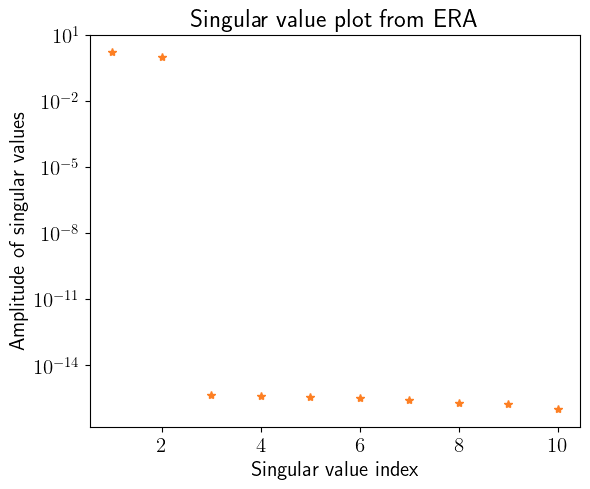

In [35]:
observer_order = 10
okid_ = sysID.okid_with_observer([input_training], [output_training], observer_order=observer_order, number_of_parameters=50)

p = 20
q = p
era_ = sysID.era(okid_.markov_parameters, state_dimension=state_dimension, p=p, q=q)

fig = plt.figure(num=1, figsize=[6, 5])

ax = fig.add_subplot(1, 1, 1)
ax.semilogy(np.linspace(1, 10, 10), np.diag(era_.Sigma)[0:10], '*', color=(253/255, 127/255, 35/255))
plt.ylabel(r'Amplitude of singular values', fontsize=15)
plt.xlabel(r'Singular value index', fontsize=15)
plt.title(r'Singular value plot from ERA', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()

x0_id = np.zeros(state_dimension)
identified_system = sysID.discrete_linear_model(frequency, x0_id, era_.A, B=era_.B, C=era_.C, D=era_.D)

Testing

In [27]:
total_time_testing = 20
number_steps_testing = int(total_time_testing * frequency + 1)
tspan_testing = np.linspace(0, total_time_testing, number_steps_testing)

input_testing = sysID.discrete_signal(frequency=frequency, data=np.sin(3 * tspan_testing))
output_testing_true = sysID.propagate(input_testing, true_system)[0]
output_testing_identified = sysID.propagate(input_testing, identified_system)[0]

Plotting

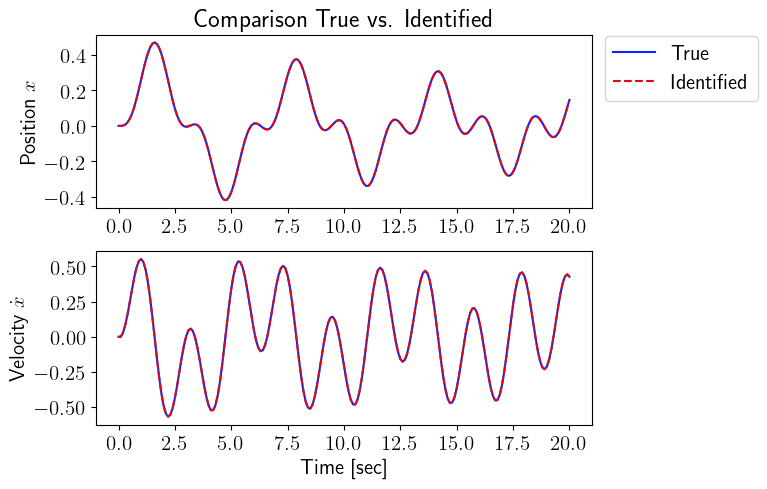

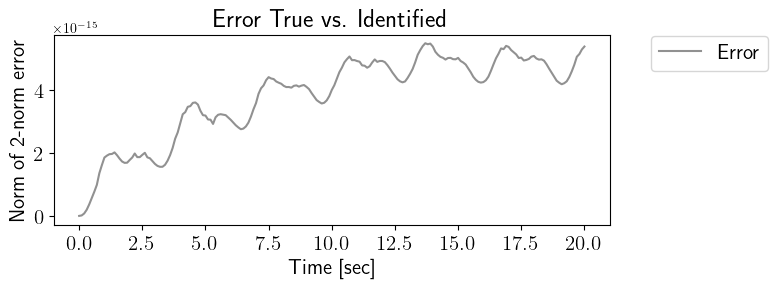

In [28]:
fig = plt.figure(num=2, figsize=[8, 5])

ax = fig.add_subplot(2, 1, 1)
ax.plot(tspan_testing, output_testing_true.data[0, :], color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(tspan_testing, output_testing_identified.data[0, :], '--', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Position $x$', fontsize=15)
plt.title(r'Comparison True vs. Identified', fontsize=18)
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.05), ncol=1, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax = fig.add_subplot(2, 1, 2)
ax.plot(tspan_testing, output_testing_true.data[1, :], color=(11/255, 36/255, 251/255))
ax.plot(tspan_testing, output_testing_identified.data[1, :], '--', color=(221/255, 10/255, 22/255))
plt.xlabel(r'Time [sec]', fontsize=15)
plt.ylabel(r'Velocity $\dot{x}$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()


fig = plt.figure(num=3, figsize=[8, 3])

ax = fig.add_subplot(1, 1, 1)
ax.plot(tspan_testing, LA.norm(output_testing_true.data - output_testing_identified.data, axis=0), color=(145/255, 145/255, 145/255), label=r'Error')
plt.ylabel(r'Norm of 2-norm error', fontsize=15)
plt.xlabel(r'Time [sec]', fontsize=15)
plt.title(r'Error True vs. Identified', fontsize=18)
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.05), ncol=1, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()

Eigenvalues

True eigenvalues: [0.99005398+0.09921166j 0.99005398-0.09921166j]
Identified eigenvalues: [0.99005398+0.09921166j 0.99005398-0.09921166j]


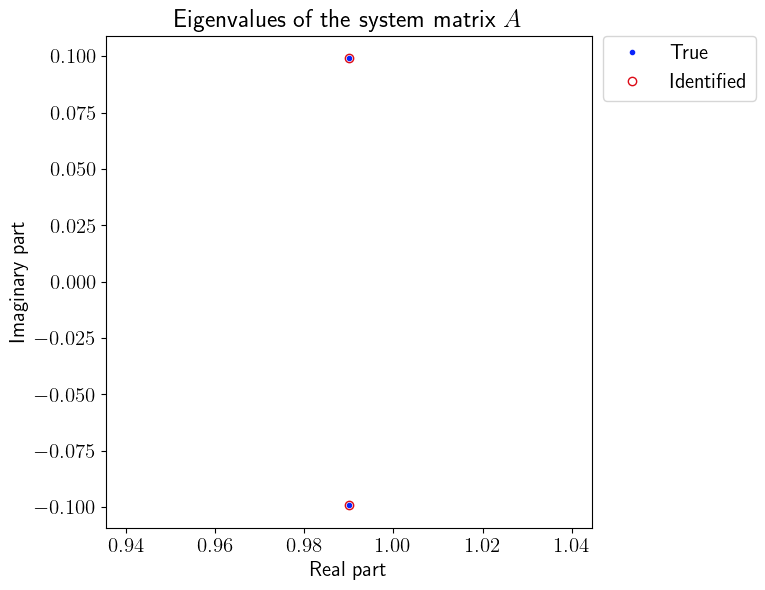

In [38]:
ev_true = LA.eig(A(0))[0]
ev_identified = LA.eig(era_.A(0))[0]
print('True eigenvalues:', ev_true)
print('Identified eigenvalues:', ev_true)

fig = plt.figure(num=4, figsize=[8, 6])

ax = fig.add_subplot(1, 1, 1)
ax.plot(np.real(ev_true), np.imag(ev_true), '.', color=(11/255, 36/255, 251/255), label=r'True')
ax.plot(np.real(ev_identified), np.imag(ev_identified), 'o', mfc='none', color=(221/255, 10/255, 22/255), label=r'Identified')
plt.ylabel(r'Imaginary part', fontsize=15)
plt.xlabel(r'Real part', fontsize=15)
plt.title(r'Eigenvalues of the system matrix $A$', fontsize=18)
ax.legend(loc='upper center', bbox_to_anchor=(1.18, 1.02), ncol=1, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.show()